In [1]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import numpy as np

In [2]:
df=pd.read_csv('edmunds.csv')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saiyam/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/saiyam/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
stop = stopwords.words('english')
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)
df['body']=df['body'].str.lower()

df['body'] = df['body'].astype(str).apply(remove_stopwords)
print(df['body'])

0       braking - sorry 70 0 braking 189 reported c & ...
1       new 2004 accord drove driveway last night . go...
2       love numbers , compare performance price numbe...
3       kd , people buy tl accord , reason bought 330 ...
4       pg48477 ... prove point . luxury primary crite...
                              ...                        
4995    `` meaningless '' guess 's meaningless actuall...
4996    guess everyone hung whole msrp value thing . g...
4997    please stop yelling ! consider used camaro z28...
4998    response exepected ... discounting areas bmw e...
4999    `` please mountain , curvy , wavy road nonsens...
Name: body, Length: 5000, dtype: object


In [4]:
# Map the brand names to the car names
mapping_df = pd.read_csv('car_models_and_brands.csv')
model_to_brand = dict(zip(mapping_df['Model'], mapping_df['Brand']))
def replace_model_with_brand(comment):
    for model, brand in model_to_brand.items():
        comment = comment.replace(model, brand)
    return comment

df['body'] = df['body'].str.lower().apply(replace_model_with_brand)

In [57]:
brands=mapping_df['Brand'].unique()
values_to_remove = ['car', 'seat', 'problem','"hyundai,"','hyundai.','"kia,"','kia.','sedan']

brands = [x for x in brands if x not in values_to_remove]

In [58]:
brand_freq = {}

# Iterate through the "body" column of the target DataFrame
for _, row in df.iterrows():
    body_text = row['body']
    # Check for NaN values and skip them
    if not isinstance(body_text, str) and np.isnan(body_text):
        continue
    
    # Split the "body" text into words
    words = body_text.split()

    words = list(set(words))

    # Count the frequency of brand names in the "body" text
    for word in words:
        if word in brands:
            brand_freq[word] = brand_freq.get(word, 0) + 1

# Now, brand_freq dictionary contains the frequency counts of brand names in the "body" column
print(brand_freq)

{'bmw': 1433, 'honda': 426, 'acura': 544, 'nissan': 293, 'subaru': 217, 'infiniti': 399, 'hyundai': 109, 'chevrolet': 106, 'toyota': 321, 'pontiac': 52, 'mercedes-benz': 205, 'audi': 413, 'ford': 128, 'mazda': 69, 'lincoln': 55, 'cadillac': 107, 'chrysler': 62, 'dodge': 55, 'volkswagen': 169, 'volvo': 122, 'mitsubishi': 22, 'saturn': 11, 'kia': 23, 'suzuki': 17, 'buick': 29, 'mercury': 5}


In [59]:
sorted_dict = sorted(brand_freq.items(), key=lambda item: item[1],reverse=True)
top_10_brands=sorted_dict[:10]
for brand, frequency in top_10_brands:
    print(f'{brand}: {frequency}')
top_10_list = [item[0] for item in top_10_brands]

bmw: 1433
acura: 544
honda: 426
audi: 413
infiniti: 399
toyota: 321
nissan: 293
subaru: 217
mercedes-benz: 205
volkswagen: 169


In [61]:
# Initialize a dictionary to store brand mentions per post
brand_mentions_per_post = {brand: set() for brand in top_10_list}

# Initialize dictionaries to store brand co-mentions and individual brand mentions
co_mentions = {}
for brand1 in top_10_list:
    co_mentions[brand1] = {}
    for brand2 in top_10_list:
        co_mentions[brand1][brand2] = 0
individual_mentions = {brand: 0 for brand in top_10_list}

# Function to calculate lift ratio between two brands
def calculate_lift(brand1, brand2, total_posts):
    if brand1 == brand2:
        return 0  # Lift ratio between the same brand is 0
    # Calculate lift using the formula: lift(brand1, brand2) = (P(brand1 and brand2) / (P(brand1) * P(brand2))) * N
    p_brand1_and_brand2 = co_mentions[brand1][brand2]
    p_brand1 = individual_mentions[brand1]
    p_brand2 = individual_mentions[brand2]
    if p_brand1 == 0 or p_brand2 == 0:
        return 0  
    else:
        return (p_brand1_and_brand2 / (p_brand1 * p_brand2)) * total_posts

# Iterate through the "body" column of the target DataFrame
for _, row in df.iterrows():
    body_text = row['body']
    
    # Check for NaN values and skip them
    if not isinstance(body_text, str) and np.isnan(body_text):
        continue
    
    # Split the "body" text into words
    words = body_text.split()
    
    # Convert words to lowercase for case-insensitive matching
    words = [word.lower() for word in words]
    
    # Keep track of previously mentioned brands in the current post
    mentioned_brands_in_post = set()
    
    for i, word in enumerate(words):
        if word in top_10_list:
            # Check if the brand was already mentioned in the current post
            if word not in mentioned_brands_in_post:
                # Increment individual mention count for the brand
                individual_mentions[word] += 1
                # Update the set of mentioned brands in the current post
                mentioned_brands_in_post.add(word)
                
                # Check for co-mentions of other brands in the same post
                for j in range(i + 1, min(i + 7, len(words))):  # Change '6' to your desired separation limit
                    if words[j] in top_10_list:
                        # Increment co-mention count for the pair of brands (both directions)
                        co_mentions[word][words[j]] += 1
                        co_mentions[words[j]][word] += 1  # Symmetric update

# Calculate total number of posts
total_posts = len(df)

lift_ratios = {}
lift_already_calculated = set()  # To keep track of already calculated lift pairs

for brand1 in top_10_list:
    for brand2 in top_10_list:
        if brand1 != brand2:
            # Ensure we calculate lift only once for each pair (ignoring the order)
            pair = tuple(sorted([brand1, brand2]))
            if pair not in lift_already_calculated:
                lift_ratio = calculate_lift(brand1, brand2, total_posts)
                lift_ratios[pair] = lift_ratio
                lift_already_calculated.add(pair)

# Sort lift ratios in descending order
sorted_lift_ratios = sorted(lift_ratios.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 unique lift ratios and associated brand pairs
for (brand1, brand2), lift_ratio in sorted_lift_ratios[:10]:
    print(f'Lift({brand1}, {brand2}) = {lift_ratio:.2f}')


Lift(honda, toyota) = 2.56
Lift(nissan, toyota) = 2.34
Lift(audi, volkswagen) = 2.08
Lift(honda, nissan) = 2.00
Lift(acura, infiniti) = 1.66
Lift(audi, mercedes-benz) = 1.36
Lift(audi, infiniti) = 1.03
Lift(acura, audi) = 0.98
Lift(acura, honda) = 0.88
Lift(bmw, infiniti) = 0.79


In [41]:
# Create a new tuple with the desired changes
updated_tuple = (sorted_lift_ratios[44][0], 0.1)

# Create a new list with the updated tuple
sorted_lift_ratios = sorted_lift_ratios[:44] + [updated_tuple] + sorted_lift_ratios[44 + 1:]



#sorted_lift_ratios[44][1]=0.001

/Users/saiyam/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


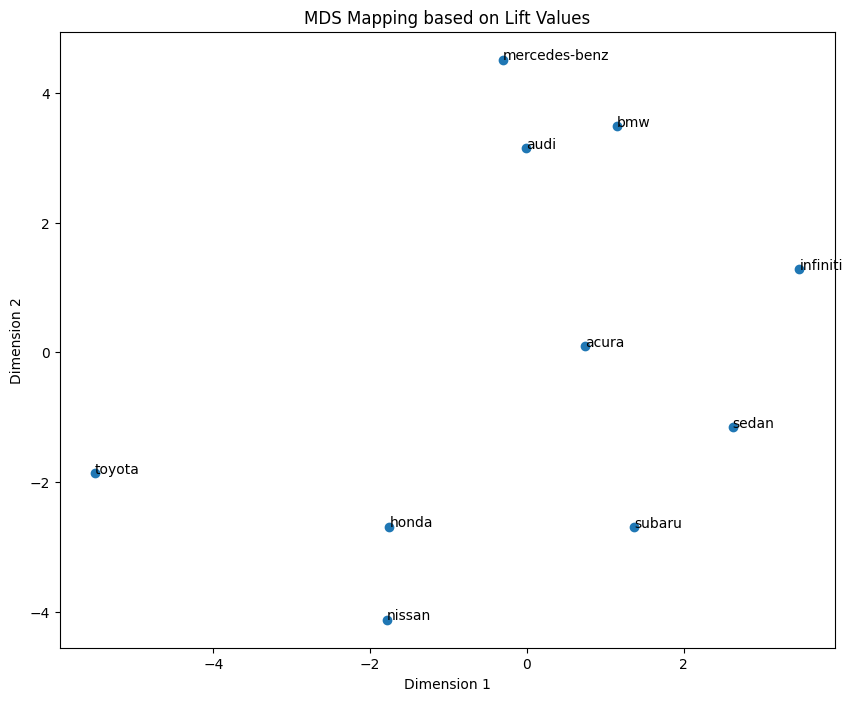

In [42]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Extract the unique brand names
brands = set()
for lift_item, _ in sorted_lift_ratios:
    brands.update(lift_item)
brands = list(brands)

# Create an empty dissimilarity matrix
n = len(brands)
dissimilarity_matrix = np.zeros((n, n))

# Fill the dissimilarity matrix with lift values
for i in range(n):
    for j in range(n):
        if i != j:
            brand_pair = (brands[i], brands[j])
            # Find the lift value for the brand pair
            for lift_item, lift_value in sorted_lift_ratios:
                if brand_pair == lift_item or brand_pair == lift_item[::-1]:
                    dissimilarity_matrix[i, j] = 1 / lift_value  # You may need to adjust this scaling
                    break

# Initialize the MDS model
mds = MDS(n_components=2, dissimilarity="precomputed")

# Fit the data and perform MDS mapping
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS results with labels
plt.figure(figsize=(10, 8))
plt.scatter(mds_result[:, 0], mds_result[:, 1])
for i, brand in enumerate(brands):
    plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))
plt.title("MDS Mapping based on Lift Values")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
